# Sources

Data compiled from otherer sources to be compared with twitter sentiment:
* Deaths from Covid-19
* Google Trends
* Market Data
* News

In [3]:
import sys, os
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from pytrends.request import TrendReq 
import matplotlib.dates as mdates
pytrend = TrendReq()
from datetime import datetime
import urllib.request, json 
from newsapi import NewsApiClient
import yfinance

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Covid-19 Deaths 

Looking at the deaths of covid 19 around the world and over time

Text(0.5, 0, 'Date')

<Figure size 432x288 with 0 Axes>

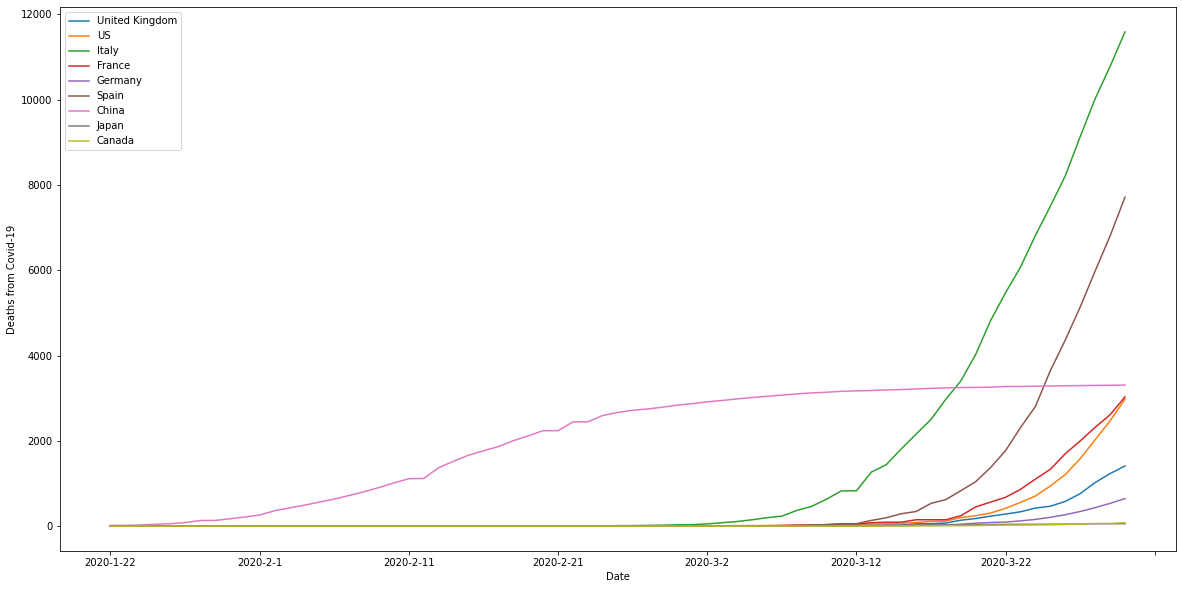

In [171]:
# JSON time-series of coronavirus cases (confirmed, deaths and recovered) per country - updated daily on github
with urllib.request.urlopen("https://pomber.github.io/covid19/timeseries.json") as url:
    data = json.loads(url.read().decode())

# creates a data fram for the deaths per country and on what day, confirmed cases and recoveries are available
# deaths are the most important indicator as testing is not widely available
index = [x['date'] for x in data['Afghanistan']]
columns = [x for x in data.keys()]
data = [[data[x][d]['deaths'] for x in data.keys()] for d in range(len(data['Afghanistan']))]
df = pd.DataFrame(data, index=index, columns=columns)


# plotting graph with reduced number of countries
df = df[['United Kingdom', 'US', 'Italy', 'France', 'Germany', 'Spain', 'China', 'Japan', 'Canada']]
plt.figure()
ax = df.plot( figsize=(20,10))
ax.set_ylabel('Deaths from Covid-19')
ax.set_xlabel('Date')

# Google Trends

Data retrieved from google trends - saved data to csv files to reduce the number of request being made

## Popular Queries 

The top 50 queries related to the words coronavirus and covid-19

In [3]:
# words to search for
keywords = ['coronavirus','covid-19']

# Obtaining the payload
pytrend.build_payload(keywords, timeframe='2020-01-01 2020-03-20')

# Obtaining related queries
related = pytrend.related_queries()
searches = related[keywords[0]]['top']['query'].append(related[keywords[1]]['top']['query'])
searches = searches.reset_index().drop(columns=["index"])['query']
print(searches)
searches = searches.to_list()
searches.extend(keywords)

0                      corona
1          coronavirus update
2        coronavirus symptoms
3            coronavirus news
4           coronavirus cases
5                corona virus
6              uk coronavirus
7                       china
8           china coronavirus
9             coronavirus map
10         italia coronavirus
11             el coronavirus
12         france coronavirus
13       sintomas coronavirus
14          coronavirus india
15             us coronavirus
16    symptoms of coronavirus
17            usa coronavirus
18          italy coronavirus
19         coronavirus españa
20           coronavirus live
21          coronavirus death
22           coronavirus tips
23        what is coronavirus
24         coronavirus latest
25       covid-19 coronavirus
26                      covid
27             covid-19 cases
28                   covid 19
29             covid-19 virus
30               covid-19 map
31          covid-19 symptoms
32              covid-19 news
33        

## Interest by Region

* Results given by google trends are *relative search volumes* RSVs
* They are standardizing for each request from 0 to 100, where 100 represents the highest share of a term over a time series (2020-01-01 2020-03-20)
* The maximum value of the index is set to be 100
* For example, if one data point is 50 and another data point is 100, this means that the number of searches satisfying the condition was half as large for the first data point as for the second data point.

In [4]:
# only allowed 5 words max per request 
# pytrend.build_payload(kw_list, timeframe='2020-01-01 2020-03-20')

# Interest by Region
# df = pytrend.interest_by_region(inc_low_vol=True)

# saving Data to a csv file
# df.to_csv(path_or_buf="../data/interest_by_region.csv",index=True)

# loading data from csv file
df = pd.read_csv(filepath_or_buffer="../data/interest_by_region.csv", index_col="geoName")

print(df)

                Coronavirus  covid-19
geoName                              
Afghanistan              97         3
Albania                  99         1
Algeria                  99         1
American Samoa           98         2
Andorra                 100         0
...                     ...       ...
Western Sahara           95         5
Yemen                    92         8
Zambia                   98         2
Zimbabwe                 98         2
Åland Islands            97         3

[250 rows x 2 columns]


## Global Historical Interest

* Numbers represent search interest relative to the highest point on the chart for the given region and time. 
* A value of 100 is the peak popularity for the term 
* A value of 50 means that the term is half as popular
* A score of 0 means there was not enough data for this term
* Data is given hourly I average over each day to plot it

Text(0, 0.5, 'Popularity')

<Figure size 432x288 with 0 Axes>

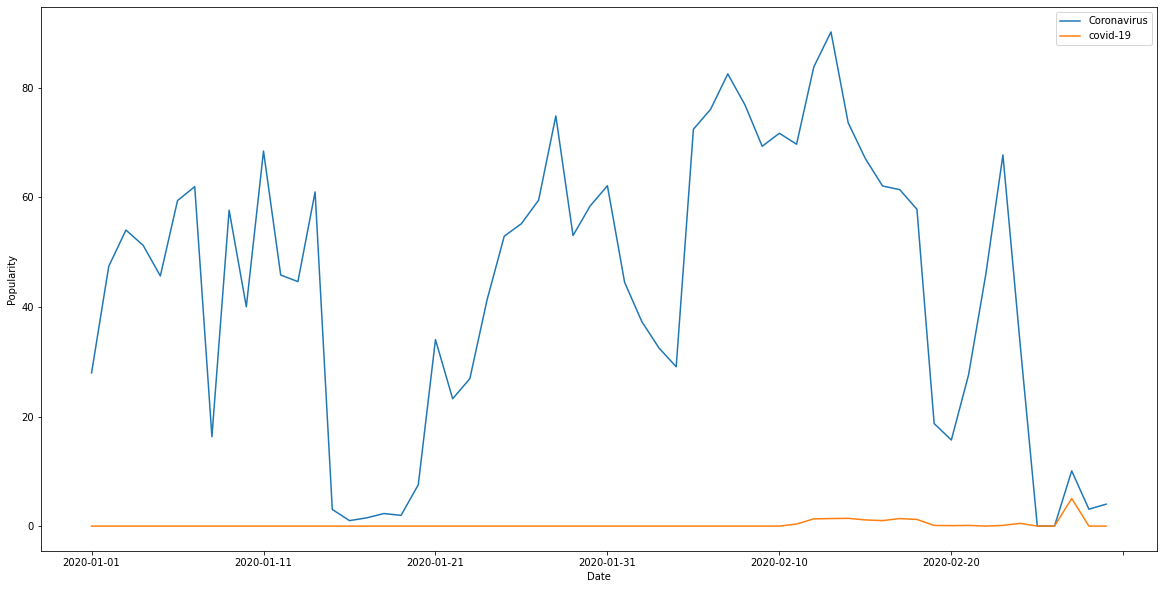

In [21]:
# retriveing data from google
# pytrend.build_payload(kw_list, timeframe='2020-01-01 2020-03-20')

# getting historical interest 
# df = pytrend.get_historical_interest(kw_list, year_start=2020, month_start=1, day_start=1, hour_start=0, year_end=2020, month_end=3, day_end=20, hour_end=0, cat=0, geo='', gprop='', sleep=0)
# df = df.reset_index()

# Seperating Date into Date and Time Columns
# df['Date'] = df['date'].dt.date
# df['Time'] = df['date'].dt.time
# df = df.drop(['date'], axis=1)
# df = df.set_index('Date')

# saving Data to a csv file
# df.to_csv(path_or_buf="../data/historical_interest.csv",index=True)

# loading data from csv file
df = pd.read_csv(filepath_or_buffer="../data/historical_interest.csv", index_col="Date")

# averaging the scores over each day
df_averaged =  df.groupby(['Date']).mean()

# plotting graph
plt.figure()
ax = df_averaged.plot(figsize=(20,10))
ax.set_ylabel('Popularity')

## Restaurant vs Delivery

An indicator for how many people are opting to stay at home before lockdowns occured

Text(0, 0.5, 'Popularity')

<Figure size 432x288 with 0 Axes>

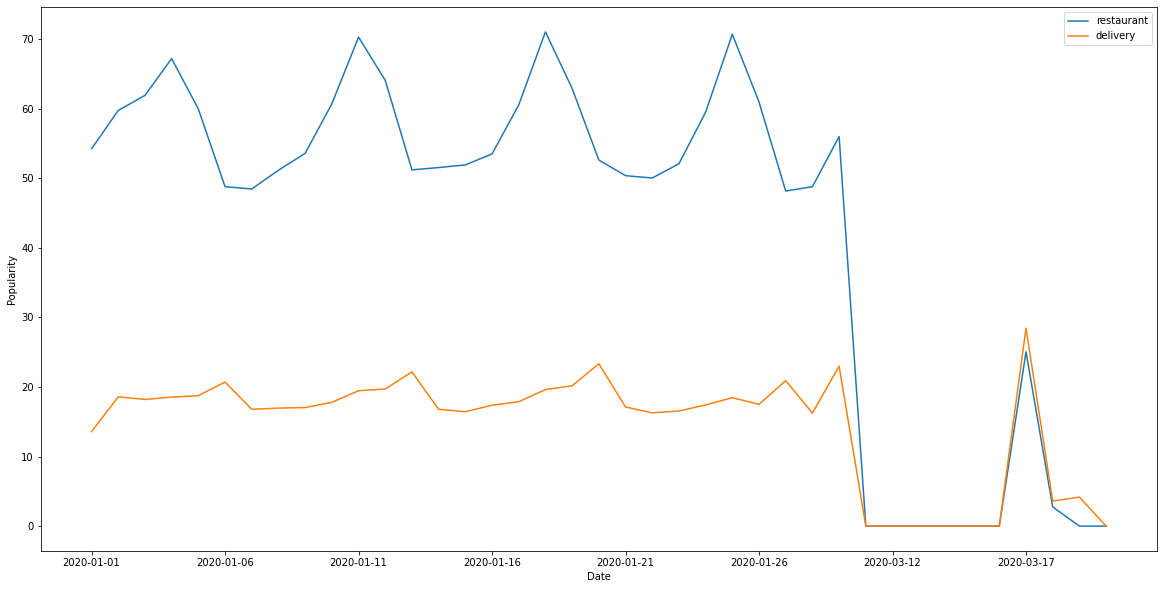

In [145]:
# retriveing data from google
# pytrend.build_payload(["restaurant", "delivery"], timeframe='2020-01-01 2020-03-20')

# getting historical interest 
# df = pytrend.get_historical_interest(["restaurant", "delivery"], year_start=2020, month_start=1, day_start=1, hour_start=0, year_end=2020, month_end=3, day_end=20, hour_end=0, cat=0, geo='', gprop='', sleep=0)
# df = df.reset_index()

# Seperating Date into Date and Time Columns
# df['Date'] = df['date'].dt.date
# df['Time'] = df['date'].dt.time
# df = df.drop(['date'], axis=1)
# df = df.set_index('Date')

# saving Data to a csv file
# df.to_csv(path_or_buf="../data/rest_del.csv",index=True)

# loading data from csv file
df = pd.read_csv(filepath_or_buffer="../data/rest_del.csv", index_col="Date")

# averaging the scores over each day
df_averaged =  df.groupby(['Date']).mean()

# plotting graph
plt.figure()
ax = df_averaged.plot(figsize=(20,10))
ax.set_ylabel('Popularity')

# Market Data

Display data for Stock Indices around the world for the last few months
Might have to normalize data so that its all on appropriate scale for now left as is

* FTSE 100 - UK 
* Dow Jones - USA
* CAC 40 - France
* Nikkei 225 - Japan
* SZSE Component Index - China
* DAX - Germany
* EURONEXT 100 - Europe


Text(0, 0.5, 'Normalized Stock Price')

<Figure size 432x288 with 0 Axes>

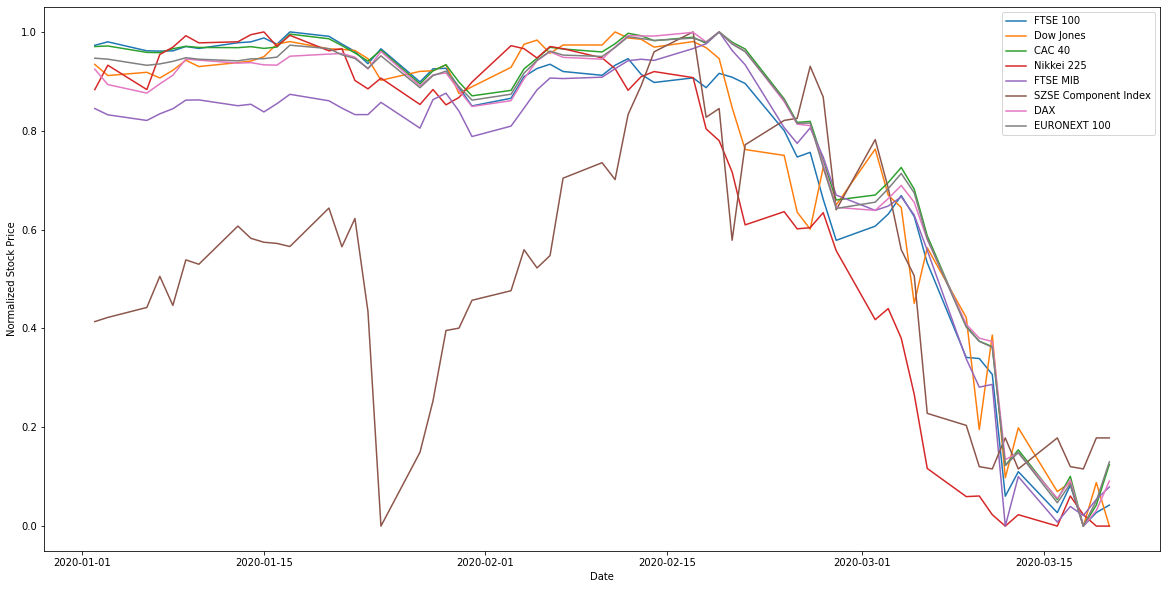

In [147]:
# reading data from csv file
df= pd.read_csv("../data/stock_market_indices.csv")

# Turning date columns into numbered duplicates
s = df.columns.to_series()
mask = df.columns.duplicated(keep=False)
c = np.where(mask, s + '_'  + (s.groupby(s).cumcount() + 1).astype(str) , s)
df.columns = c

# lists for columns in the dataset
dates = ['Date','Date.1','Date.2','Date.3','Date.4','Date.5','Date.6','Date.7']
indices = ["FTSE 100", "Dow Jones ", "CAC 40", "Nikkei 225", "FTSE MIB", "SZSE Component Index","DAX","EURONEXT 100"]

# turning dates with times into just dates
df[dates] = df[dates].apply(pd.to_datetime, format='%m/%d/%Y %H:%M:%S')
for d in dates: df[d] = df[d].dt.date

# merging date columns into one filling any missing entries with 
df = pd.concat([df[[d, i]].rename(columns={d: 'Date'}) for d in dates for i in indices]).dropna(how='all')
df = df.groupby('Date',as_index=False).apply(lambda x:x.ffill().bfill().drop_duplicates())

# removing duplicate rows
df = df.drop_duplicates(['Date']).set_index(['Date'])

# Normalizing the data
df=(df-df.min())/(df.max()-df.min())

# displaying the dataframe
plt.figure()
ax = df.plot(figsize=(20,10))
ax.set_ylabel('Normalized Stock Price')

# News

Retrieving news from the newsapi only allowed to make a max of 500 requests and onkly allowed to view last month of data.

In [110]:
# retrieving API Token
# f = open("../news_token.txt", "r")
# token = f.read().strip()

# # Init
# # newsapi = NewsApiClient(api_key=token)

start = "2020-03-01"
end = "2020-03-31"

start_date = datetime.strptime(start,'%Y-%m-%d')
end_date = datetime.strptime(end,'%Y-%m-%d')

days = pd.date_range(start=start,end=end).to_pydatetime().tolist()
day_list  = [datetime.strftime(d,'%Y-%m-%d') for d in days]

# sources = newsapi.get_sources()['sources']
# s_names = [ sources[s]['id'] for s in range(len(sources))]
# print(s_names)
# countries = list( dict.fromkeys( [ sources[s]['country'] for s in range(len(sources)) ] ))
# countries = ['us', 'gb','fr', 'es','it', 'de', 'zh', 'ru']
# # print(countries, len(countries))

# # getting all articles mentioning coronavirus
sources = ["bbc-news", "cnn", "fox-news", "die-zeit","google-news-fr", "google-news-it", "xinhua-net"]
data = [[0 for x in range(len(sources))] for y in range(len(day_list))] 
for d in range(len(day_list)):
    for s in range(len(sources)):
        news = newsapi.get_everything(q='coronavirus',sources=sources[s],from_param=day_list[d],to=day_list[d])
        day_mentions = news['totalResults']    
        data[d][s] = day_mentions

df = pd.DataFrame(data, index=days, columns=sources)

# saving Data to a csv file
df.to_csv(path_or_buf="../data/news_mentions.csv",index=True)
print(df)

# # loading data from csv file
# df = pd.read_csv(filepath_or_buffer="../data/news_mentions.csv")

# displaying the dataframe
plt.figure()
ax = df.plot(figsize=(20,10))
ax.set_ylabel('Articles that mention coronavirus')

NewsAPIException: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 500 requests over a 24 hour period (250 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}